# GRN between Cell Types

This Notebook is part of the Bachelorthese from David Wild.

The goal of this notebook is to find out gene-gene interactions between different cell types. We want as a result a GRN that not only describes which genes express which, but also how much (weighted graph) and in which direction (exhibiting, inhibiting).  
Another aspect that would be interesting are finding co-factors.


In [1]:
try:
    # Check if this gets executed in google colab. 
    # If so, then we need to install pip packages and clone the repo and data
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [2]:
if IN_COLAB:
    !pip install scanpy
    !pip install torch
    !pip install matplotlib
    !pip install pandas
    !pip install numpy
    !pip install seaborn
    !pip install scipy
    !pip install -U -q PyDrive
else:
    !pip install -r requirements.txt

/bin/bash: line 1: /home/atr0x/Documents/UNI/WS2025/BachelorArbeit/GAE-gene-interactions/.venv/bin/pip: cannot execute: required file not found


In [3]:
if IN_COLAB:
    !git clone https://github.com/DavidWild02/BachelorThesis-ML-Gene-Interactions.git
    %cd ./BachelorThesis-ML-Gene-Interactions

In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r /content/drive/MyDrive/DavidWildBachelorthesis/data .

In [5]:
import scanpy as sc
import pandas as pd
import numpy as np

adata = sc.read_h5ad("./data/subdom_processed.h5ad")
adata

AnnData object with n_obs × n_vars = 2671 × 13144
    obs: 'n_genes_by_counts', 'total_counts', 'clusters', 'ct_num_exp_genes', 'ct_score', 'ct_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ct_gene_corr', 'ct_correlates'
    uns: 'clusters_colors', 'clusters_sizes', 'ct_params', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'log_tpm', 'spliced', 'tpm', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
adata.to_df().head()

,SUB2.g1,SUB2.g2,SUB2.g3,SUB2.g4,SUB2.g5,SUB2.g6,SUB2.g7,SUB2.g8,SUB2.g9,SUB2.g10,...,SUB2.g13135,SUB2.g13136,SUB2.g13137,SUB2.g13138,SUB2.g13139,SUB2.g13140,SUB2.g13141,SUB2.g13142,SUB2.g13143,SUB2.g13144
AAACCCAAGGACAGCT-1,0.009687,-1.032545,-1.566363,1.018223,-0.933981,-0.410398,-0.349553,-0.444472,-0.132447,-0.567418,...,0.0,0.0,0.0,-0.293056,0.0,0.0,0.0,0.0,-0.365098,-0.652811
AAACCCAAGGGTTTCT-1,1.598354,-0.300789,-0.202161,-0.002592,0.181964,0.269252,-0.393041,0.037609,0.115123,-0.754939,...,0.0,0.0,0.0,-0.192047,0.0,0.0,0.0,0.0,-0.296943,-0.677305
AAACCCACAAATGGTA-1,-0.777102,-0.792809,-1.281675,1.262175,-0.185155,-0.726397,-0.455605,-0.671795,-0.448440,-0.868259,...,0.0,0.0,0.0,-0.315716,0.0,0.0,0.0,0.0,-0.205751,0.327006
AAACCCATCGAGAAGC-1,0.696619,-0.306533,0.700373,-1.587061,-0.054666,0.263420,-0.105024,0.250046,0.661372,-0.186924,...,0.0,0.0,0.0,-0.300775,0.0,0.0,0.0,0.0,-0.310817,-0.878208
AAACCCATCTTGTTAC-1,-1.319795,-1.191836,-1.658409,1.626106,-0.142163,-1.176196,-0.391015,-0.537126,-0.254368,-0.777899,...,0.0,0.0,0.0,-0.301799,0.0,0.0,0.0,0.0,-0.303617,-0.420889


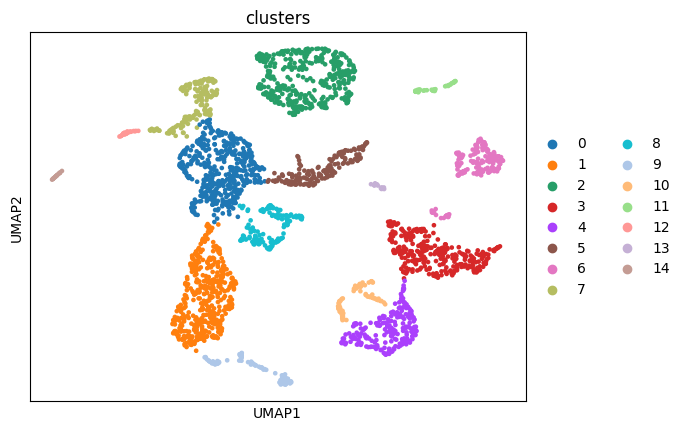

In [7]:
sc.pl.umap(adata, color="clusters")

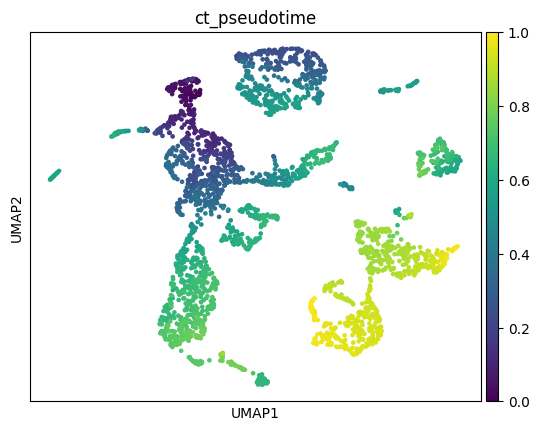

In [8]:
sc.pl.umap(adata, color="ct_pseudotime")

In the data set the data is already preprocessed, clustered and also the pseudo-time was calculated on it. The pseudo-time is a time approximation, measured on how specified the cell is in terms of how many genes are expressed. The idea is that more specialized cells have fewer expressed genes.

We already have a GRN, but it is global, we would prefer a single GRN for each cell-type to cell-type transition. Also we want a weighted GRN and the GRN at the moment is a binary matrix.
One method to construct such GRNs is by just using a Masked Linear Regression. The weight matrix of this linear regression would then be the adjacency matrix of the GRN.

To look if the approach is feasible at all, we will first only do that for stem cells (cluster 7) to transition cells (cluster 0).  
After that we validate how well prediction is (accuracy, residual plot) and how well the GRN correlates to existing knowledge.
Also how non linear models like Neural networks perform in comparison.

In [9]:
from IPython.display import display

#  load data global GRN
df_grn = pd.read_csv("./data/transcription_factor_adjacency_matrix.csv", index_col="gene_ids")
print("transcription factor adjacency matrix")
df_grn = df_grn.transpose()

# This approach seemed to make no real difference
#
# # index = target gene, column = transcription factors
# # We want to ensure here, that every gene can be influenced by itself
# target_genes = df_grn_original.index
# transcription_genes = df_grn_original.columns.union(target_genes)
# df_grn = pd.DataFrame(np.zeros((len(target_genes), len(transcription_genes))), 
#                       columns=transcription_genes, 
#                       index=target_genes)
# df_grn.loc[df_grn_original.index, df_grn_original.columns] = df_grn_original
# for i in df_grn.index:
#     df_grn.loc[i, i] = 1.
df_grn.head()

transcription factor adjacency matrix


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SUB2.g231,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
SUB2.g755,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
SUB2.g902,1,1,1,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
SUB2.g924,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1


The Linear Regression should take samples from cluster A and predict samples in cluster B. The mappings a->b are sampled randomly.  
Of course this approach could be enhanced with other techniques, that search for a better mapping. Like Optimal Transport for example.

In [10]:
np.random.seed(42) # set seed to make reproducible outputs

In [11]:
from itertools import islice
from sklearn.model_selection import GridSearchCV
from MaskedRidgeRegressor import MaskedRidgeRegressor
from sampling import RandomMappingSampler

# TODO: let num_samples also be a float. in that case it should sample a percentage of all possible associations a*b
def sample_associations(samples_cluster_a: pd.DataFrame, samples_cluster_b: pd.DataFrame, 
                        sampler, num_samples=1000, **kwargs):
    sample_indices = list(islice(iter(sampler), num_samples))
    sample_indices_a = list(map(lambda x: x[0], sample_indices))
    sample_indices_b = list(map(lambda x: x[1], sample_indices))

    X = samples_cluster_a.iloc[sample_indices_a]
    y = samples_cluster_b.iloc[sample_indices_b]

    return X, y

def train_model_for_cluster_to_cluster_association(
        df_cluster_a: pd.DataFrame, df_cluster_b: pd.DataFrame,
        mask_grn: np.ndarray, sampler=None, **kwargs):
    if sampler is None:
        sampler = RandomMappingSampler(df_cluster_a, df_cluster_b)
    X, y = sample_associations(df_cluster_a, df_cluster_b, sampler)

    param_grid = {
        "lr": [0.1, 0.01]
    }

    model = MaskedRidgeRegressor(mask_grn, epochs=500, **kwargs)
    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X.to_numpy(), y.to_numpy())
    best_estimator = grid_search.best_estimator_
    print("best parameters:", grid_search.best_params_)
    print("best score:", grid_search.best_score_)

    return best_estimator


In [12]:
def extract_samples_of_cell_cluster(adata, cluster_id: str) -> pd.DataFrame:
    obs_mask_cell_cluster = adata.obs["clusters"].values == cluster_id
    samples_cell_cluster = adata.X[obs_mask_cell_cluster, :]
    df_stem_cells = pd.DataFrame(samples_cell_cluster,
                                        index=adata.obs_names[obs_mask_cell_cluster],
                                        columns=adata.var_names)
    return df_stem_cells

stem_cells_cluster_id = '7'
transition_cells_cluster_id = '0'

df_stem_cells = extract_samples_of_cell_cluster(adata, stem_cells_cluster_id)
df_transition_cells = extract_samples_of_cell_cluster(adata, transition_cells_cluster_id)

df_stem_cells = df_stem_cells[df_grn.index]
df_transition_cells = df_transition_cells[df_grn.columns]

print(f"Shape of stem cells: {df_stem_cells.shape}")
print(f"Shape of transition cells: {df_transition_cells.shape}")

Shape of stem cells: (151, 68)
Shape of transition cells: (453, 5582)


In [13]:

grn_mask = df_grn.values
model = train_model_for_cluster_to_cluster_association(df_stem_cells, df_transition_cells, grn_mask, use_bias=False)
weighted_grn = model.W_
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

Epoch 499: 100%|██████████| 500/500 [00:15<00:00, 32.06it/s, loss=0.293]

best parameters: {'lr': 0.1}
best score: -0.3120628446340561


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0.000000,0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.0,0.0,0.0,-0.0,...,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,-0.0,-0.00000,0.00000,-0.000000
SUB2.g231,-0.000000,-0.000000,-0.000000,-0.0,-0.0,0.001418,0.0,-0.0,-0.0,0.0,...,0.0,0.0,-0.000000e+00,0.000000,-0.008452,0.090328,0.0,-0.00000,-0.00000,0.000000
SUB2.g755,-0.000000,-0.000000,-0.023775,0.0,-0.0,-0.000000,-0.0,0.0,0.0,0.0,...,0.0,0.0,-0.000000e+00,0.000278,-0.000000,-0.000000,-0.0,-0.00000,0.00000,-0.000000
SUB2.g902,-0.004433,0.025825,0.018184,-0.0,-0.0,-0.000000,0.0,0.0,-0.0,0.0,...,0.0,-0.0,-3.652826e-12,-0.019872,-0.002293,0.000000,0.0,-0.00000,-0.00000,-0.000000
SUB2.g924,0.000000,0.000000,0.000654,0.0,0.0,0.000000,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,0.000000e+00,-0.000000,-0.000000,-0.041776,0.0,-0.02651,-0.01377,-0.086375


To validate how good the regression model explains the data we use the R2-Score.

$$
R^2 = 1 - \frac{\sum{\left( y - \hat{y} \right)^2}}{\sum{\left( y - \overline{y} \right)^2}}
$$

The R2-Score can range from 1 to -1:
- 1 means that the model predicts perfectly the data.
- 0 means the model does not better than predicting the average
- -1 means the model does worse than predicting the average

From the output below we can see, that the regression for most genes outputs a R2-score of nearly 0. That means our model predicts the average. This was as expected, because we randomly sample associations between X and y. So which cells of A (stem cells) "evolve" to cells of B (transition cells).

Some genes have a very bad score (negative). This means that probably some explanatory variables are missing or that the relationship is non linear. 

In [14]:
from sklearn.metrics import r2_score

def calculate_genes_r2_score(y, y_pred) -> pd.DataFrame:
    if isinstance(y, pd.DataFrame):
        y = y.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values

    genes_r2_score = [ r2_score(y[:, i], y_pred[:, i]) for i in range(y.shape[1])]

    genes_r2_score = np.array([genes_r2_score]).T
    df_gen_scores = pd.DataFrame(genes_r2_score, index=df_grn.columns, columns=["r2_score"])
    df_gen_scores = df_gen_scores.sort_values(by="r2_score", ascending=False)

    return df_gen_scores

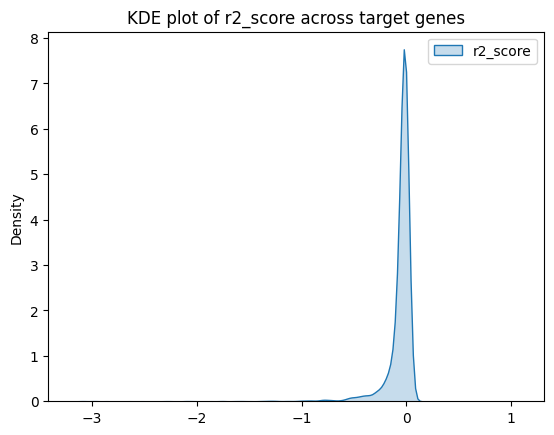

,r2_score
gene_ids,
SUB2.g11253,1.000000
SUB2.g7156,0.068070
SUB2.g7229,0.066573
SUB2.g967,0.061999
SUB2.g4130,0.061379


,r2_score
gene_ids,
SUB2.g10075,-15.790699
SUB2.g12623,-17.198320
SUB2.g11674,-88.588470
SUB2.g10238,-164.987244
SUB2.g4797,-834.079773


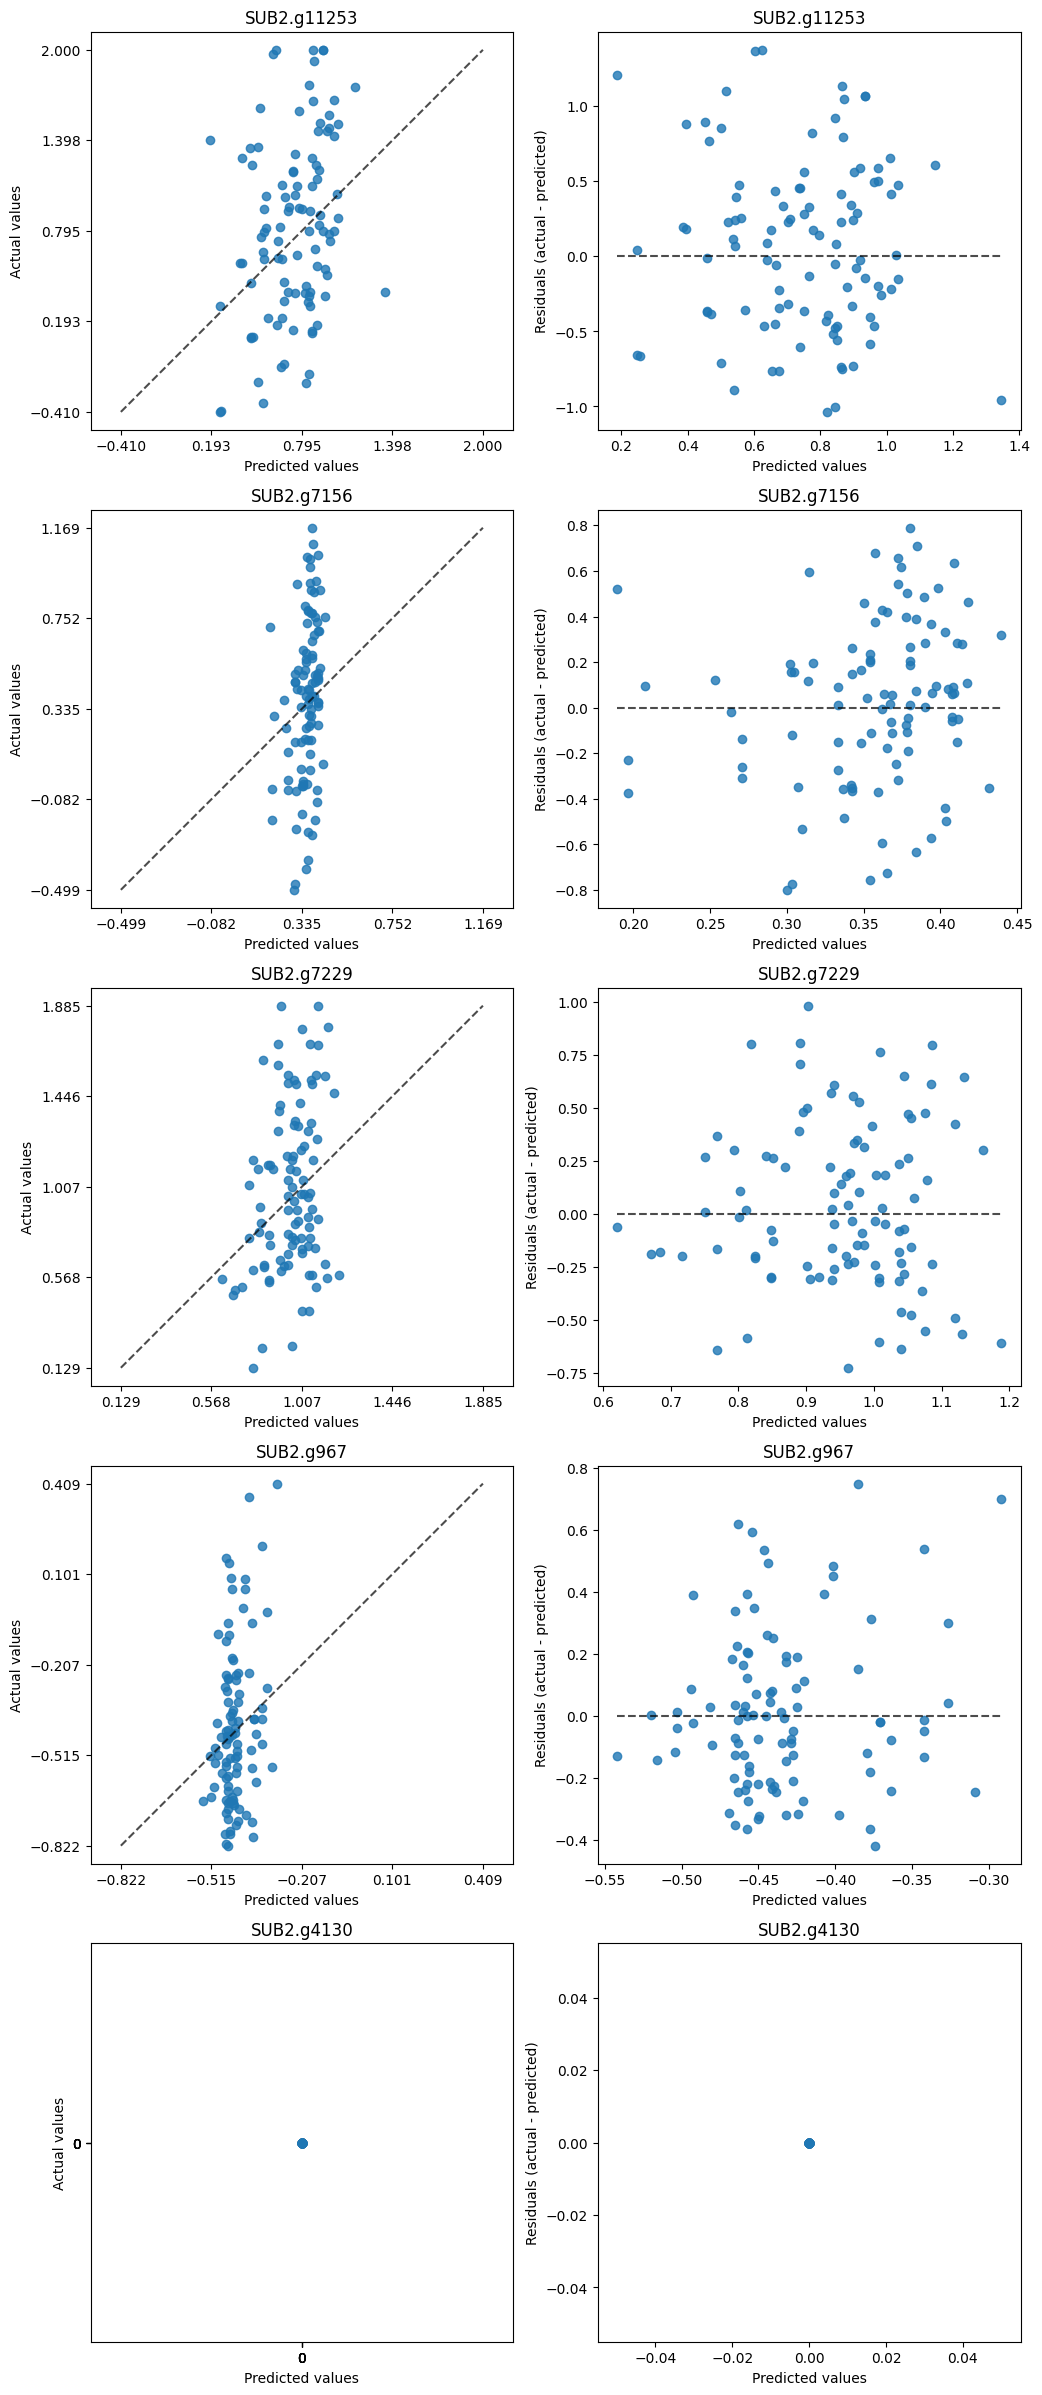

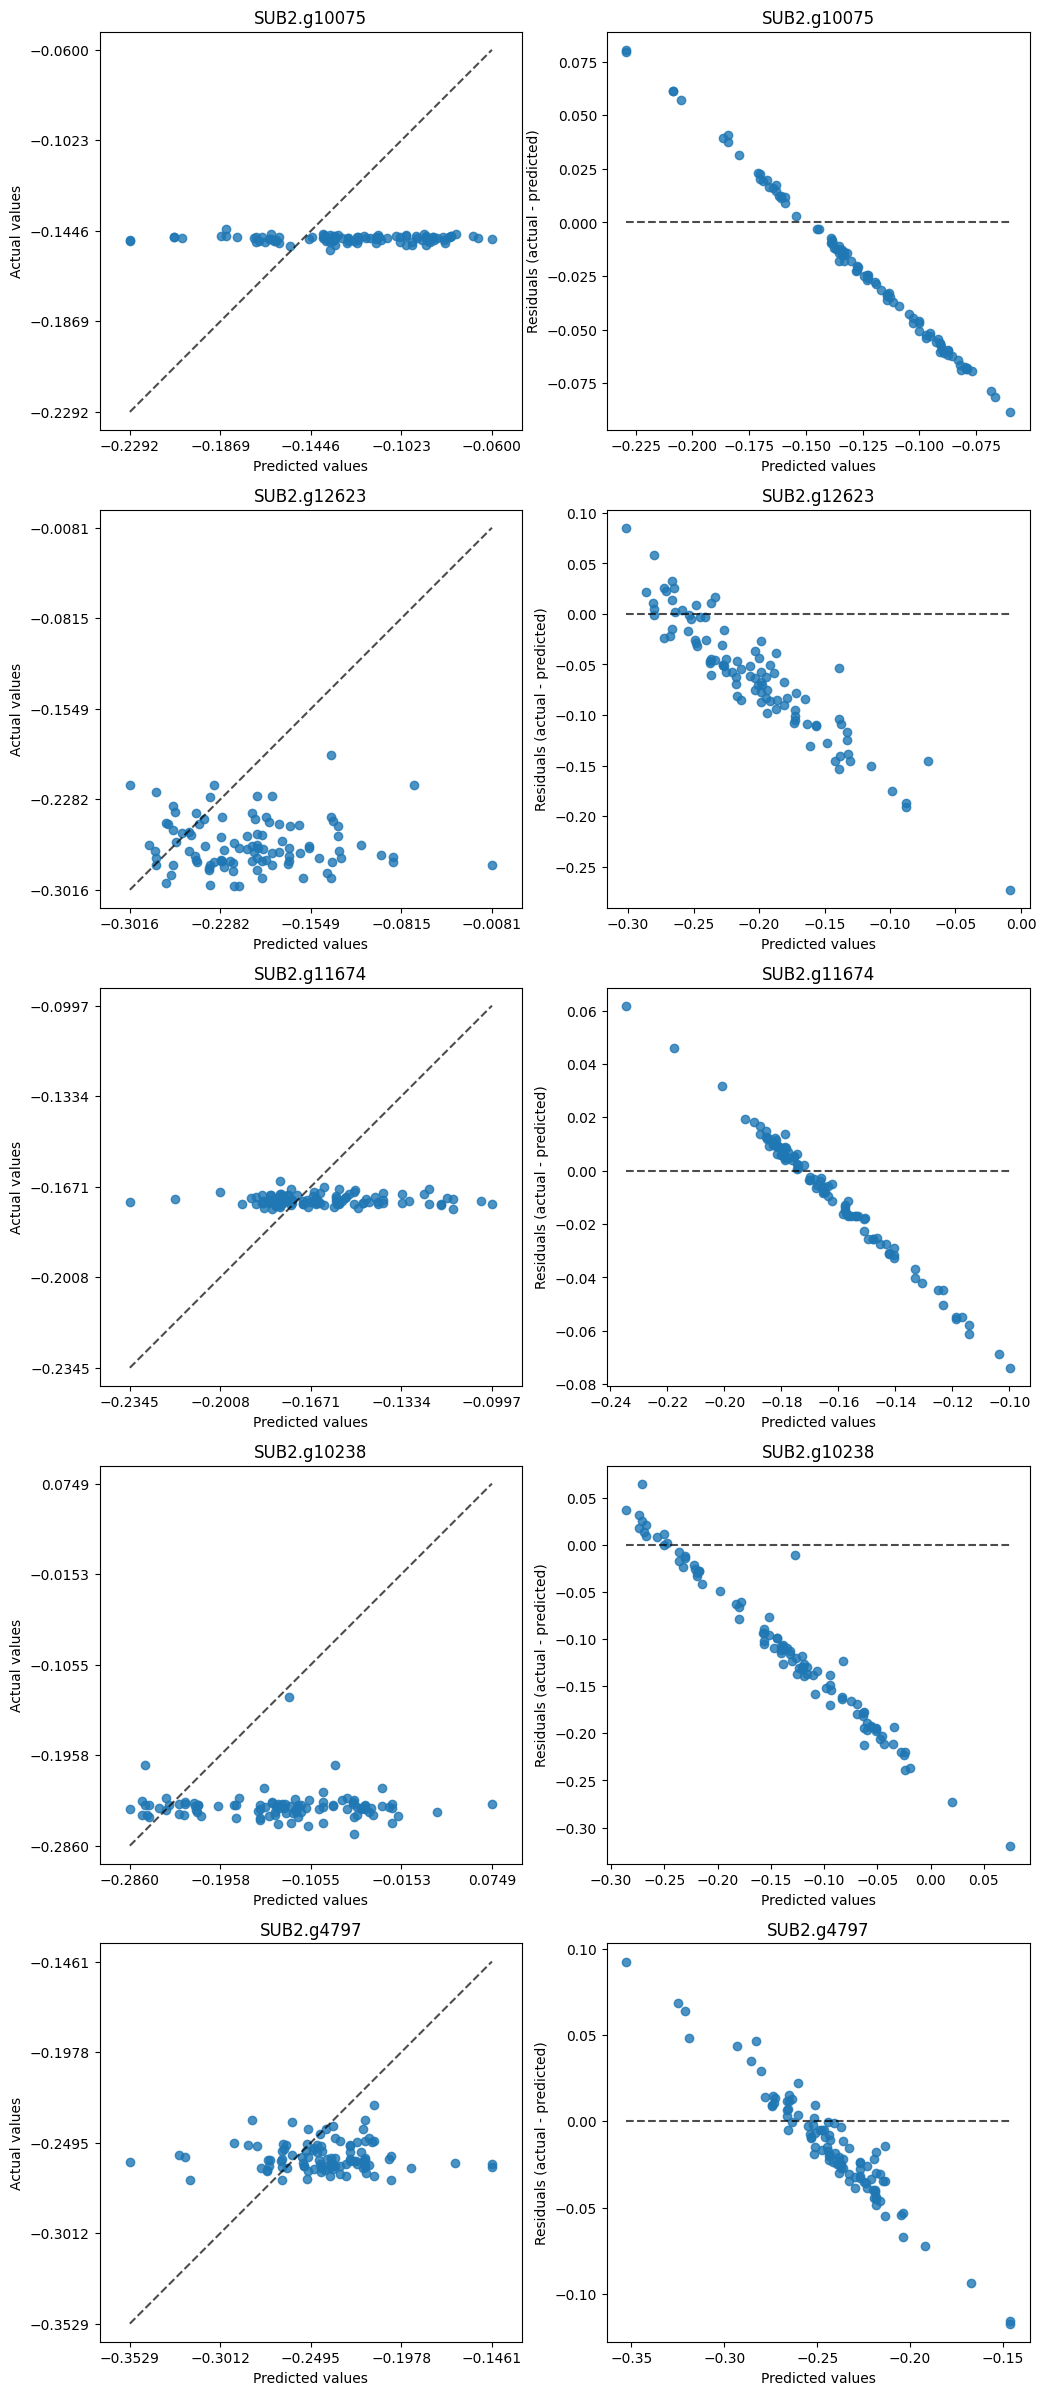

In [15]:
from plotting import show_score_distribution, display_gene_residual_plots

sampler = RandomMappingSampler(df_stem_cells, df_transition_cells)
X_test, y_test = sample_associations(df_stem_cells, df_transition_cells, sampler, num_samples=100)
y_pred = model.predict(X_test.values)
df_gen_scores = calculate_genes_r2_score(y_test, y_pred)

show_score_distribution(df_gen_scores, "r2_score")

display(df_gen_scores.head())
display(df_gen_scores.tail())

display_gene_residual_plots(y_test, y_pred, df_gen_scores.head().index, df_grn)
display_gene_residual_plots(y_test, y_pred, df_gen_scores.tail().index, df_grn)

As we can see the overall R2-Score for the whole data is -0.3. So the model performs worse than predicting the average. When we then look at the distribution of the r2-Scores for each single gene, we can see that the model actually is not that bad, but instead only for some single genes, that have a highly negative r2-score.  
From the residual plots and prediction error plots we can interpret that for those genes a variable is probably missing. I came to this conclusion, because the "predicted vs actual" plots show that for a more or less constant value, the model seems sto randomly make predictions. So it is not capable of making correct predictions by using the known variables.

In the next section I will repeat the experiment, but now by including a bias term for the Masked linear regression model. With that it performs better, because it "replaces" the missing variables for predicting the mean.

In [16]:
df_genes_with_missing_variables = df_gen_scores[df_gen_scores["r2_score"] < -0.1]
display(df_genes_with_missing_variables)

,r2_score
gene_ids,
SUB2.g1136,-0.100226
SUB2.g6128,-0.100339
SUB2.g4608,-0.100434
SUB2.g3708,-0.100474
SUB2.g992,-0.100635
...,...
SUB2.g10075,-15.790699
SUB2.g12623,-17.198320
SUB2.g11674,-88.588470


In [17]:

grn_mask = df_grn.values
model = train_model_for_cluster_to_cluster_association(df_stem_cells, df_transition_cells, grn_mask, use_bias=True)
weighted_grn = model.W_
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

Epoch 499: 100%|██████████| 500/500 [00:15<00:00, 31.26it/s, loss=0.265]


best parameters: {'lr': 0.1}
best score: -0.004544737690594047


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,-0.000000,0.00000,0.000000,-0.0,-0.0,-0.000000,0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.000000e+00,0.000000,0.000000,-0.000000,0.0,-0.000000,-0.000000,-0.000000
SUB2.g231,0.000000,-0.00000,-0.000000,0.0,0.0,0.000972,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.000000e+00,0.000000,-0.000147,0.008909,-0.0,0.000000,0.000000,-0.000000
SUB2.g755,0.000000,0.00000,0.006391,0.0,0.0,-0.000000,-0.0,0.0,0.0,0.0,...,0.0,-0.0,0.000000e+00,0.001127,0.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
SUB2.g902,0.000102,-0.00204,-0.000206,-0.0,0.0,-0.000000,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,1.478028e-11,-0.000309,0.000922,0.000000,0.0,-0.000000,-0.000000,-0.000000
SUB2.g924,0.000000,-0.00000,0.003231,-0.0,-0.0,0.000000,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.000000e+00,0.000000,0.000000,0.005032,-0.0,-0.000769,0.002387,-0.001365


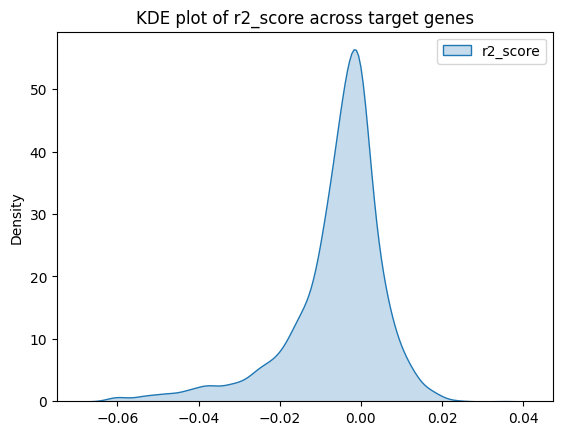

,r2_score
gene_ids,
SUB2.g3109,0.035390
SUB2.g9258,0.024547
SUB2.g7531,0.023884
SUB2.g1856,0.022728
SUB2.g1729,0.020996


,r2_score
gene_ids,
SUB2.g9690,-0.092578
SUB2.g11681,-0.137976
SUB2.g2720,-0.170464
SUB2.g2452,-0.208310
SUB2.g2804,-0.411959


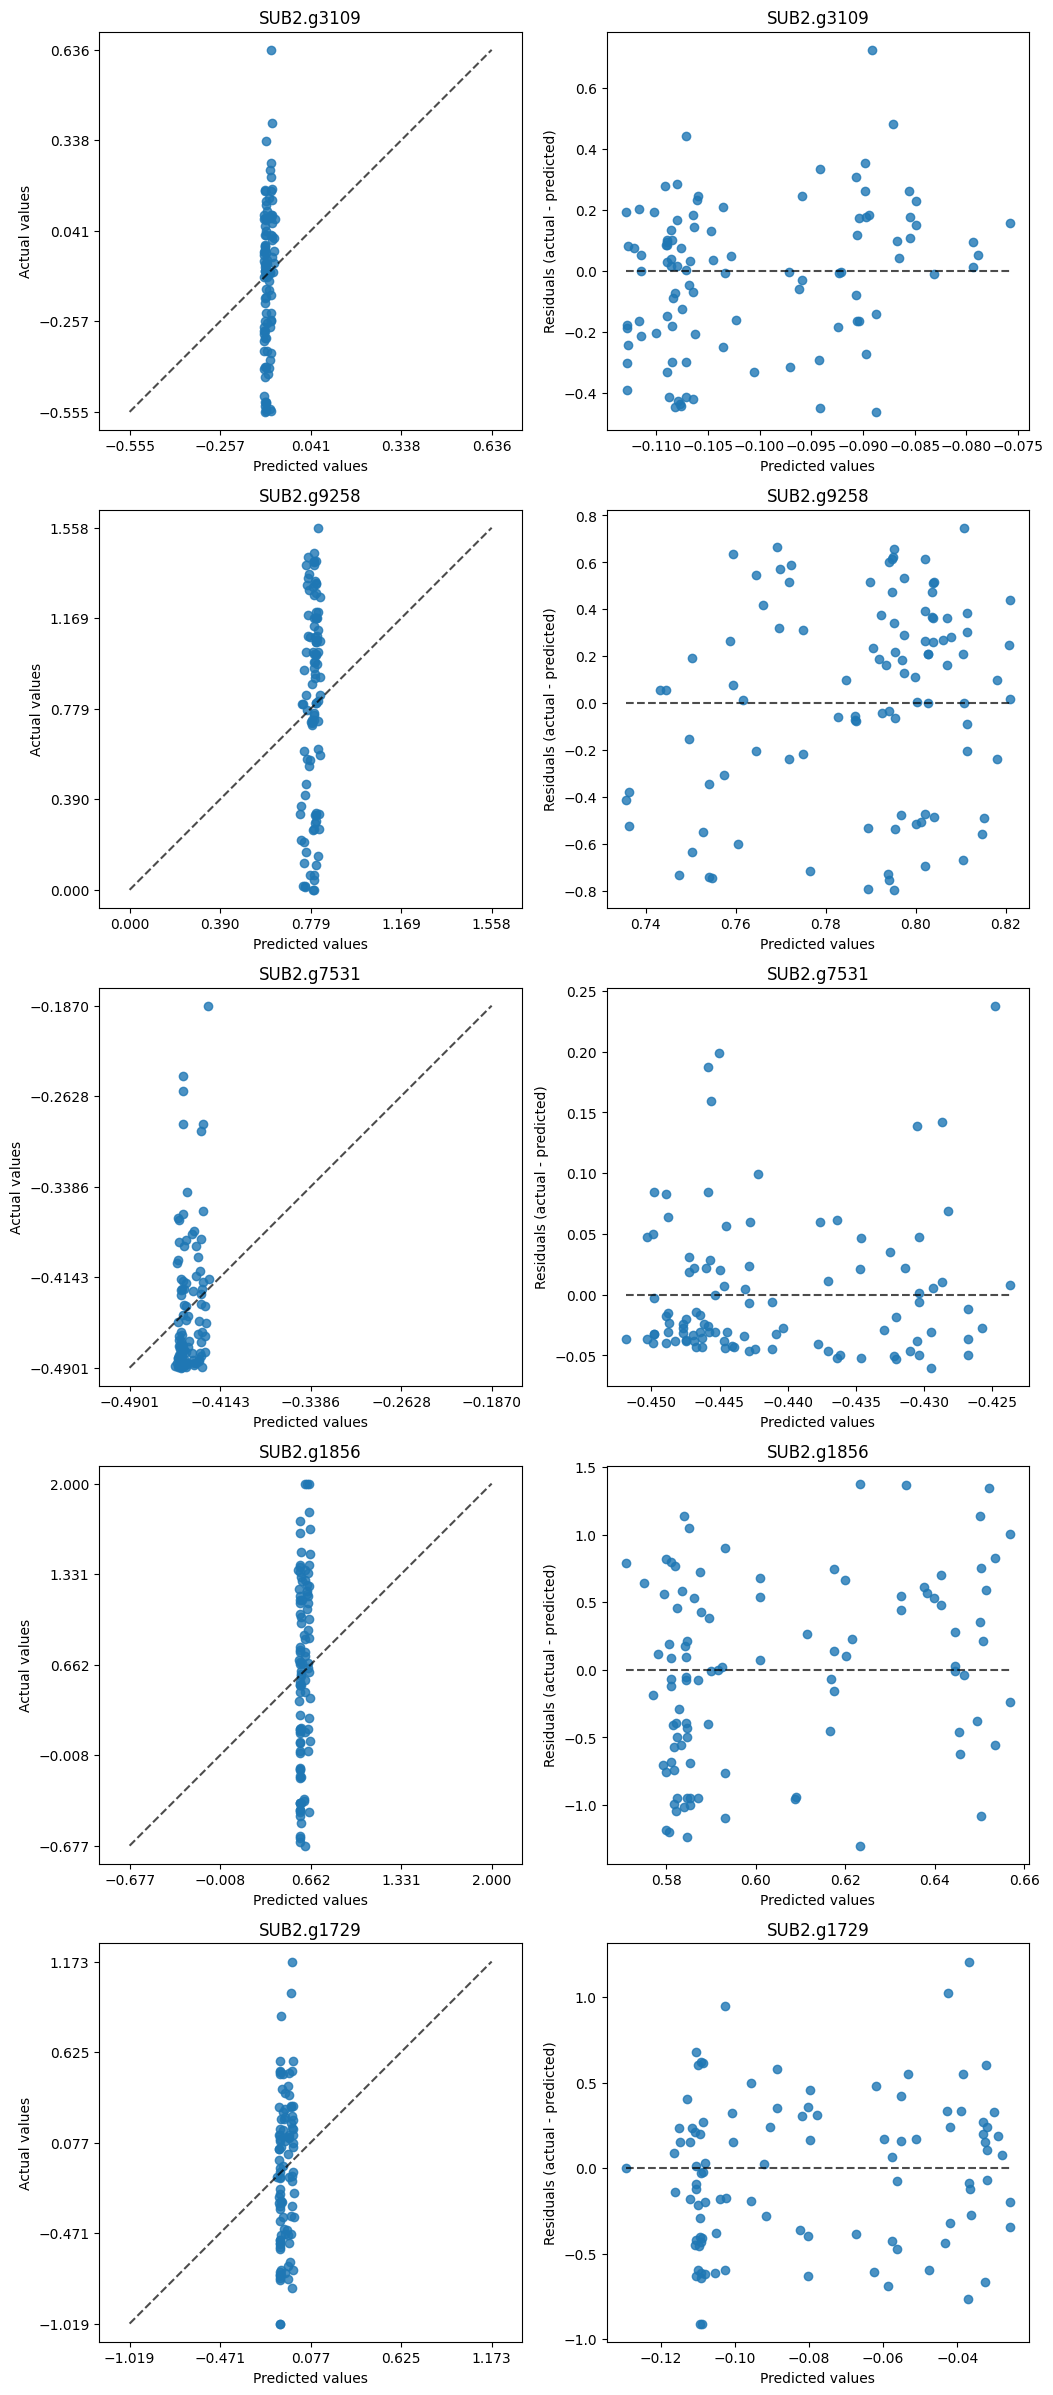

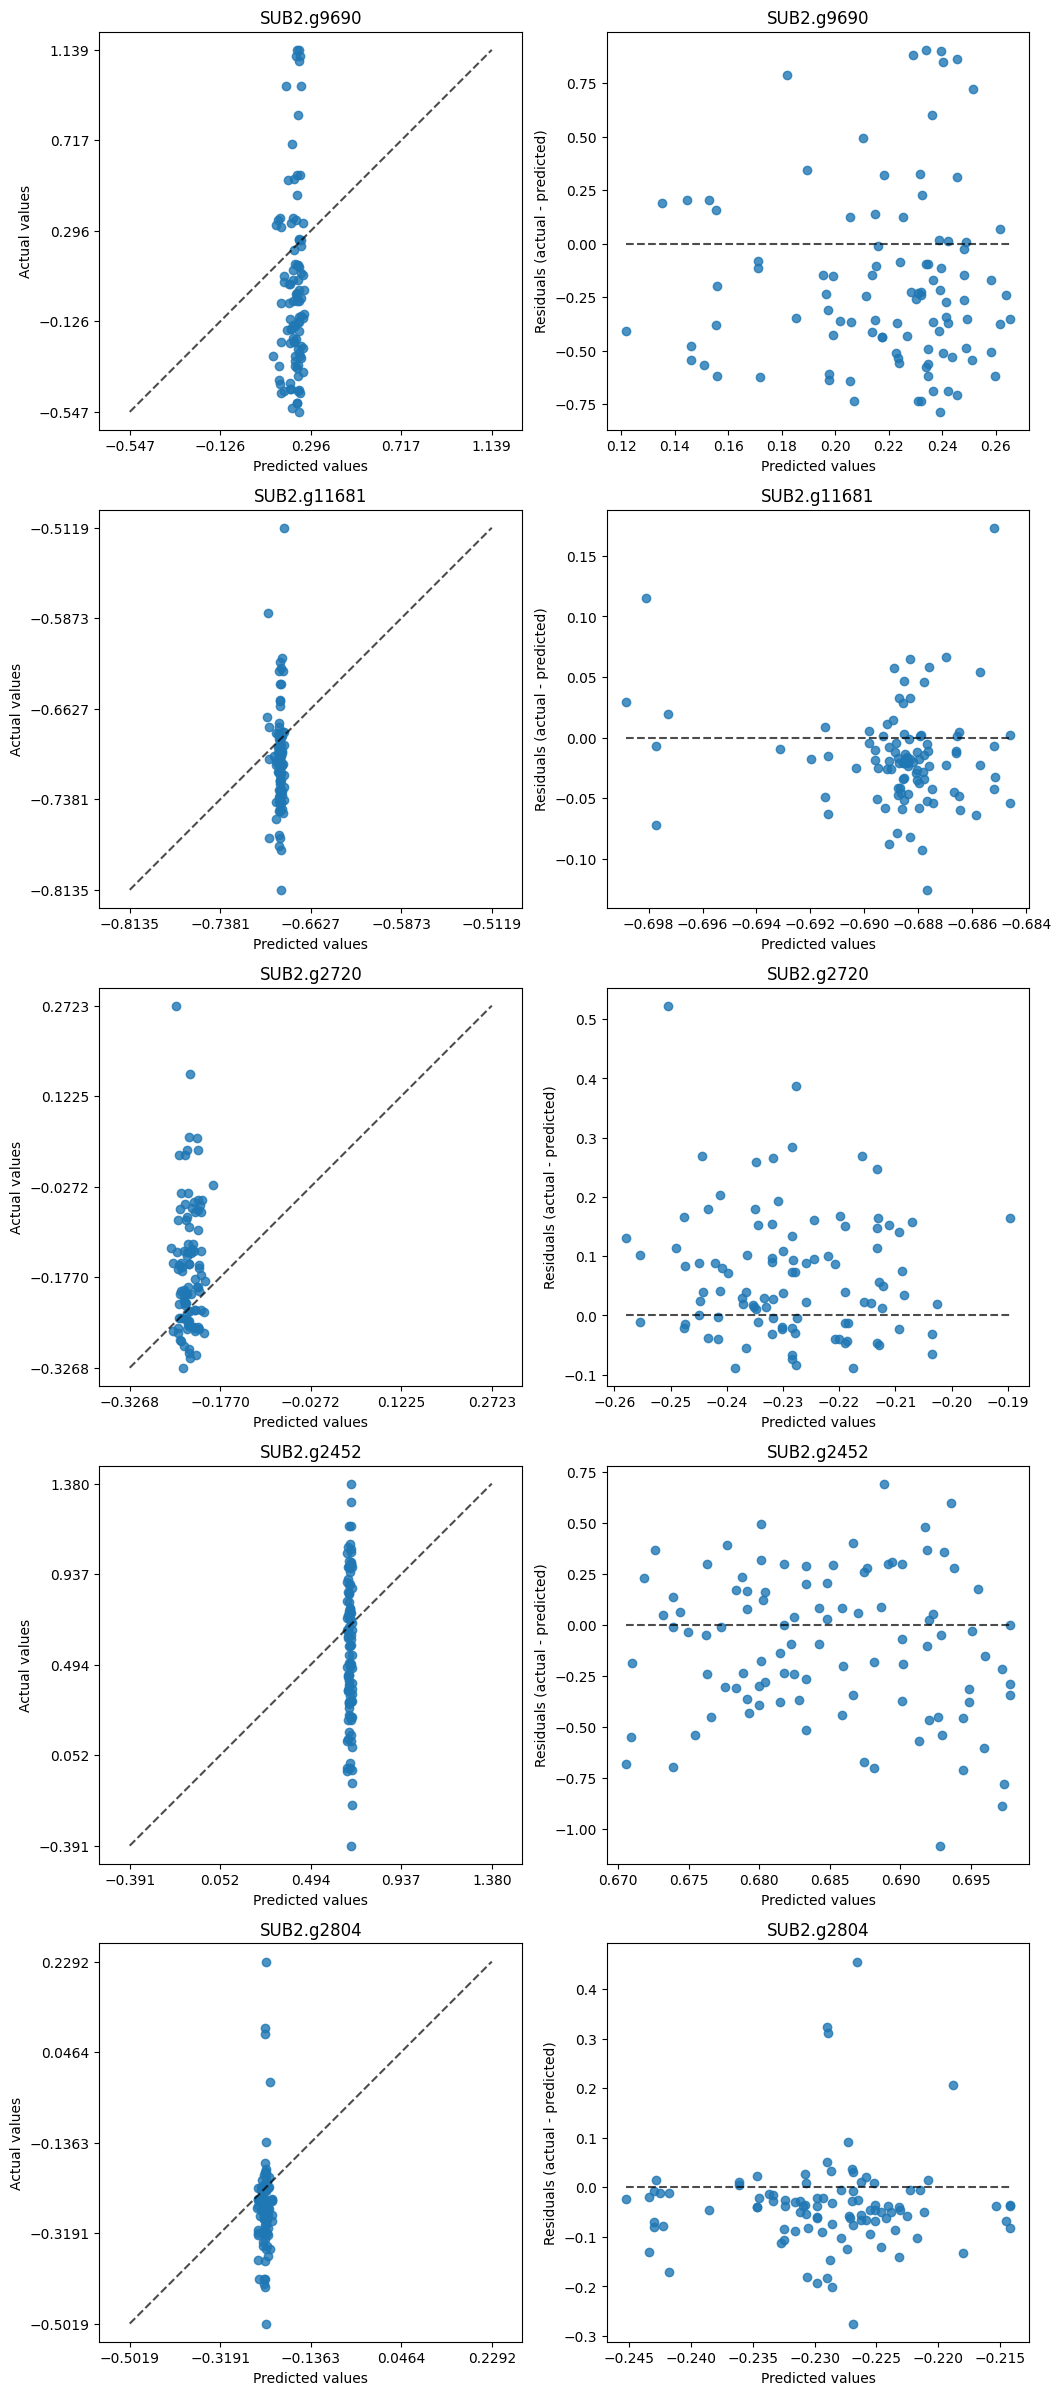

In [18]:
y_pred = model.predict(X_test)
df_gen_scores = calculate_genes_r2_score(y_test, y_pred)

show_score_distribution(df_gen_scores, "r2_score")

display(df_gen_scores.head())
display(df_gen_scores.tail())

display_gene_residual_plots(y_test, y_pred, df_gen_scores.head().index, df_grn)
display_gene_residual_plots(y_test, y_pred, df_gen_scores.tail().index, df_grn)


Now the main problem of the approach is that random sampling will lead to the model only predicting the mean, because there are no meaningful associations (they are random) and so no underlying pattern to learn.  

Now I will try out to include pseudo time data into the data, so that the regression model gets as input X not only the genes of cell A but also the pseudo time of A and the pseudo time of the target cell B. The output y stays the same, it will be the expression values for the genes of B.

<Axes: xlabel='ct_pseudotime', ylabel='Density'>

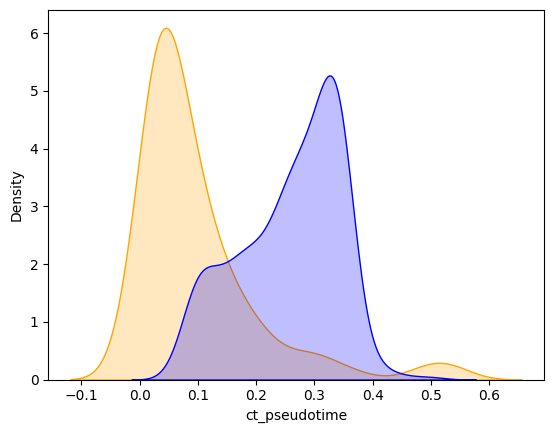

In [19]:
import seaborn as sns

df_pseudo_time_stem_cells = adata.obs["ct_pseudotime"][df_stem_cells.index]
df_pseudo_time_transition_cells = adata.obs["ct_pseudotime"][df_transition_cells.index]

sns.kdeplot(df_pseudo_time_stem_cells, color="orange", fill=True)
sns.kdeplot(df_pseudo_time_transition_cells, color="blue", fill=True)

In [43]:
def train_model_for_cluster_to_cluster_association_with_pseudo_time(
        df_cluster_a: pd.DataFrame, df_cluster_b: pd.DataFrame,
        df_pseudo_time_a: pd.Series, df_pseudo_time_b: pd.Series,
        mask_grn: np.ndarray, sampler=None, **kwargs):
    if sampler is None:
        sampler = RandomMappingSampler(df_cluster_a, df_cluster_b)
    X, y = sample_associations(df_cluster_a, df_cluster_b, sampler)
    
    X["pseudo_time"] = df_pseudo_time_a.loc[X.index].values
    X["target_pseudo_time"] = df_pseudo_time_b.loc[y.index].values

    one_vector = np.ones(mask_grn.shape[1])
    mask_grn_with_pseudo_time = np.vstack([mask_grn, one_vector, one_vector])

    param_grid = {
        "lr": [0.1, 0.01]
    }

    model = MaskedRidgeRegressor(mask_grn_with_pseudo_time, epochs=500, **kwargs)
    grid_search = GridSearchCV(model, param_grid, cv=4)
    grid_search.fit(X.to_numpy(), y.to_numpy())
    best_estimator = grid_search.best_estimator_
    print("best parameters:", grid_search.best_params_)
    print("best score:", grid_search.best_score_)

    return best_estimator

In [56]:
grn_mask = df_grn.values
model = train_model_for_cluster_to_cluster_association_with_pseudo_time(
        df_stem_cells, df_transition_cells, df_pseudo_time_stem_cells, df_pseudo_time_transition_cells,
        grn_mask, use_bias=False)
weighted_grn = model.W_[:-2, :] # the last two rows are for pseudo time
df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
df_weighted_grn.head()

/tmp/ipykernel_1379569/1190096336.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pseudo_time"] = df_pseudo_time_a.loc[X.index].values
/tmp/ipykernel_1379569/1190096336.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["target_pseudo_time"] = df_pseudo_time_b.loc[y.index].values
Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s, loss=4.82]

Epoch 499: 100%|██████████| 500/500 [00:15<00:00, 32.67it/s, loss=0.296]


best parameters: {'lr': 0.1}
best score: -0.23360223323106766


gene_ids,SUB2.g1,SUB2.g2,SUB2.g11,SUB2.g16,SUB2.g18,SUB2.g21,SUB2.g22,SUB2.g26,SUB2.g27,SUB2.g31,...,SUB2.g12978,SUB2.g12979,SUB2.g12980,SUB2.g13052,SUB2.g13056,SUB2.g13090,SUB2.g13093,SUB2.g13119,SUB2.g13123,SUB2.g13134
SUB2.g8,0.000000,0.000000,0.000000,0.0,-0.0,-0.000000,-0.0,0.0,0.0,0.0,...,-0.0,0.0,0.000000e+00,0.000000,-0.000000,0.000000,-0.0,-0.000000,-0.000000,-0.000000
SUB2.g231,-0.000000,-0.000000,-0.000000,0.0,-0.0,-0.016733,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.000000e+00,0.000000,-0.009881,0.073682,-0.0,0.000000,0.000000,0.000000
SUB2.g755,0.000000,-0.000000,-0.029517,0.0,0.0,0.000000,-0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.000000e+00,-0.001744,-0.000000,-0.000000,0.0,0.000000,0.000000,0.000000
SUB2.g902,0.033125,-0.027393,-0.013071,-0.0,0.0,-0.000000,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-3.854578e-12,-0.021920,0.000037,-0.000000,-0.0,-0.000000,0.000000,-0.000000
SUB2.g924,0.000000,-0.000000,0.025029,-0.0,0.0,0.000000,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.000000e+00,0.000000,0.000000,-0.043581,-0.0,0.002767,-0.053503,-0.044493


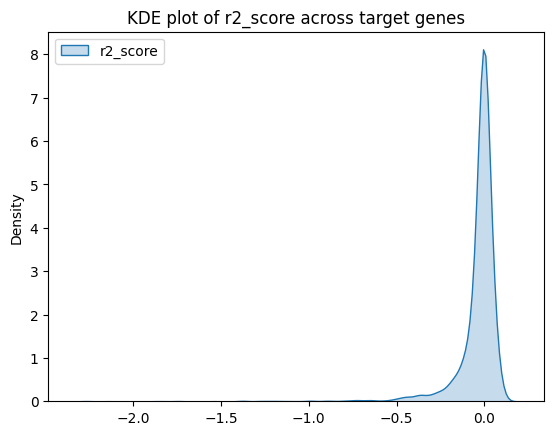

,r2_score
gene_ids,
SUB2.g5174,0.136164
SUB2.g11288,0.121455
SUB2.g3245,0.121199
SUB2.g6400,0.119388
SUB2.g3763,0.112825


,r2_score
gene_ids,
SUB2.g5908,-10.869812
SUB2.g12623,-14.488569
SUB2.g11674,-53.741051
SUB2.g10238,-135.873352
SUB2.g4797,-667.913696


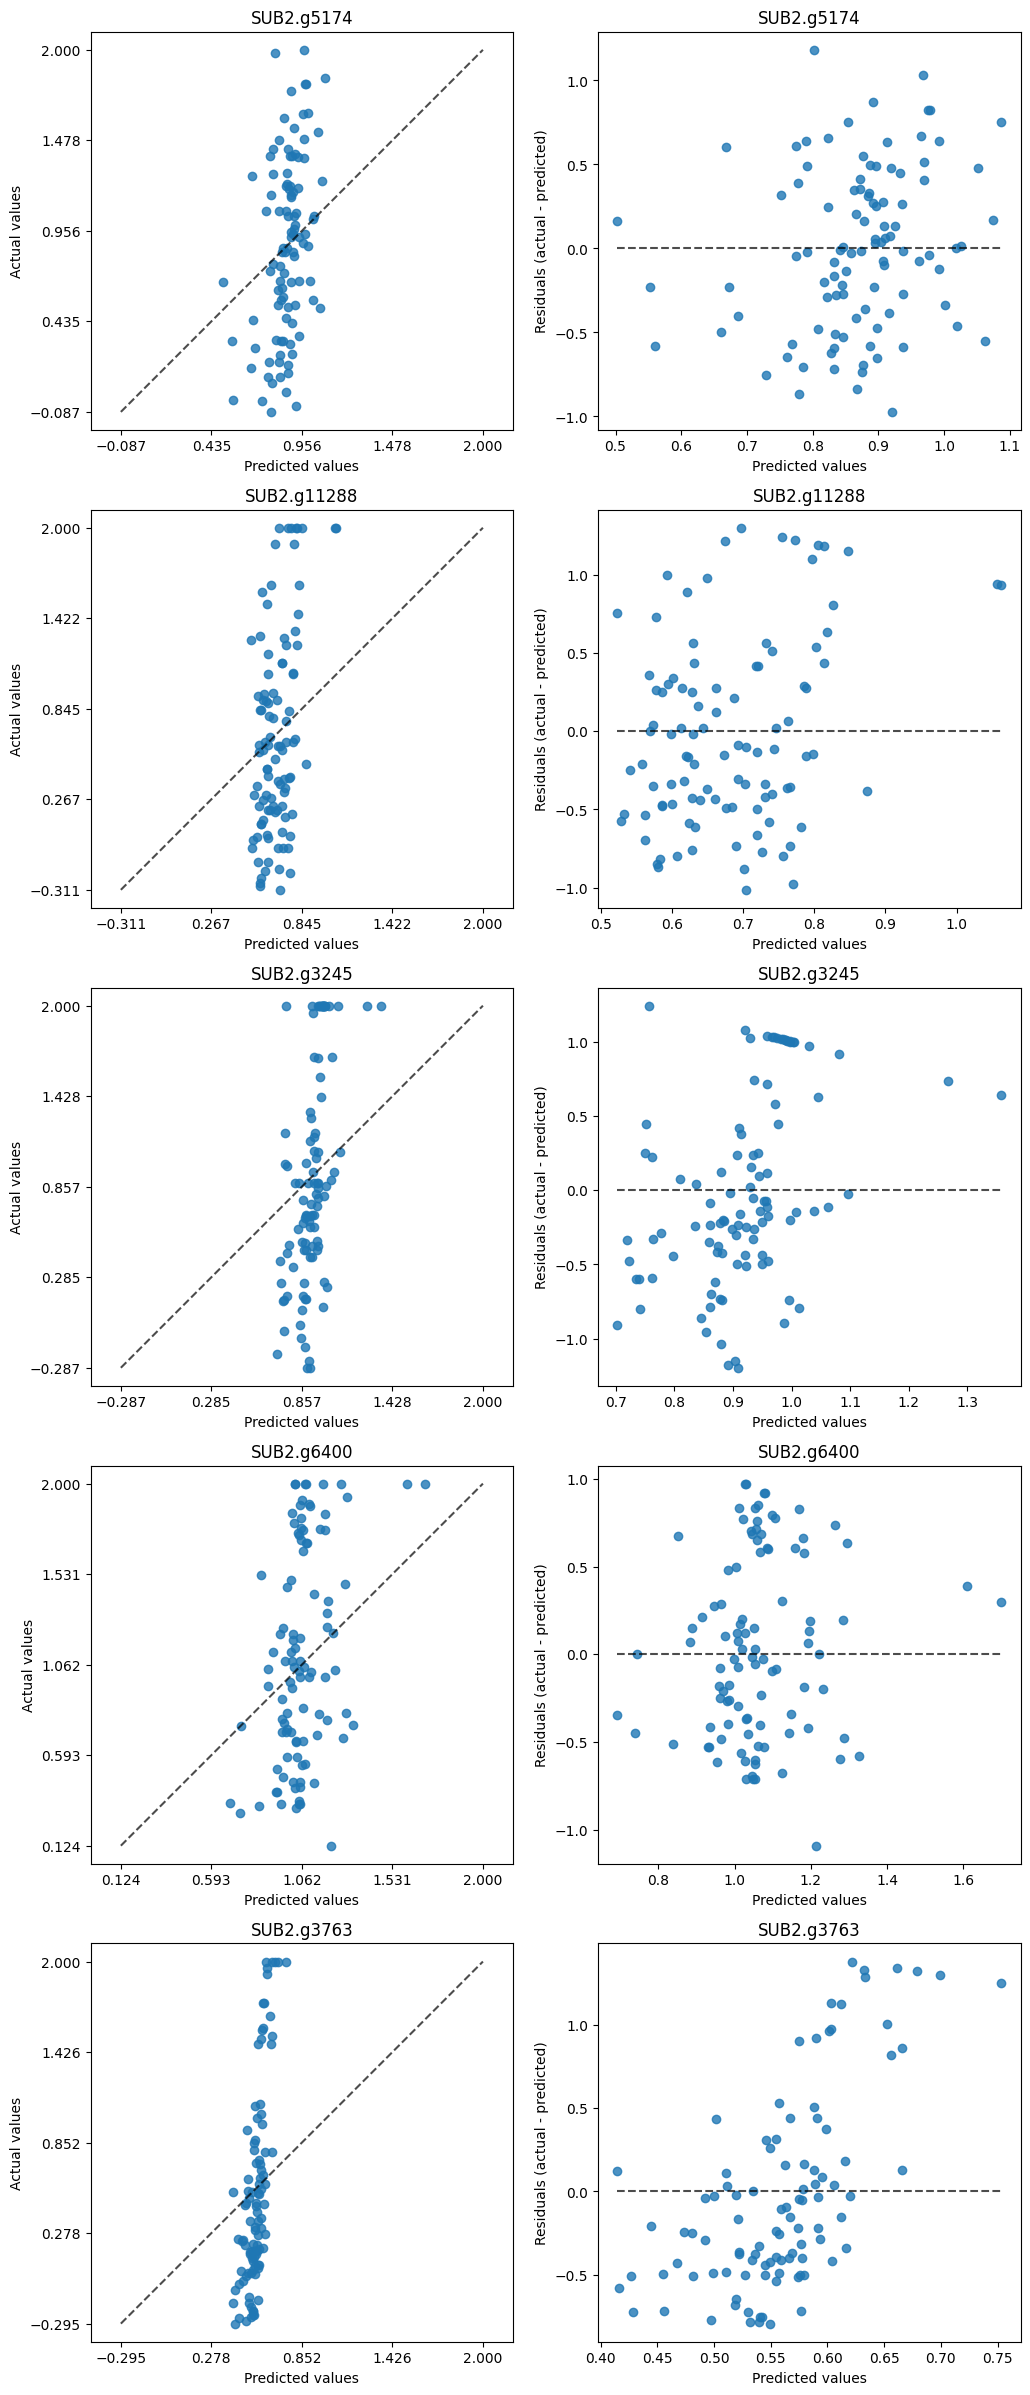

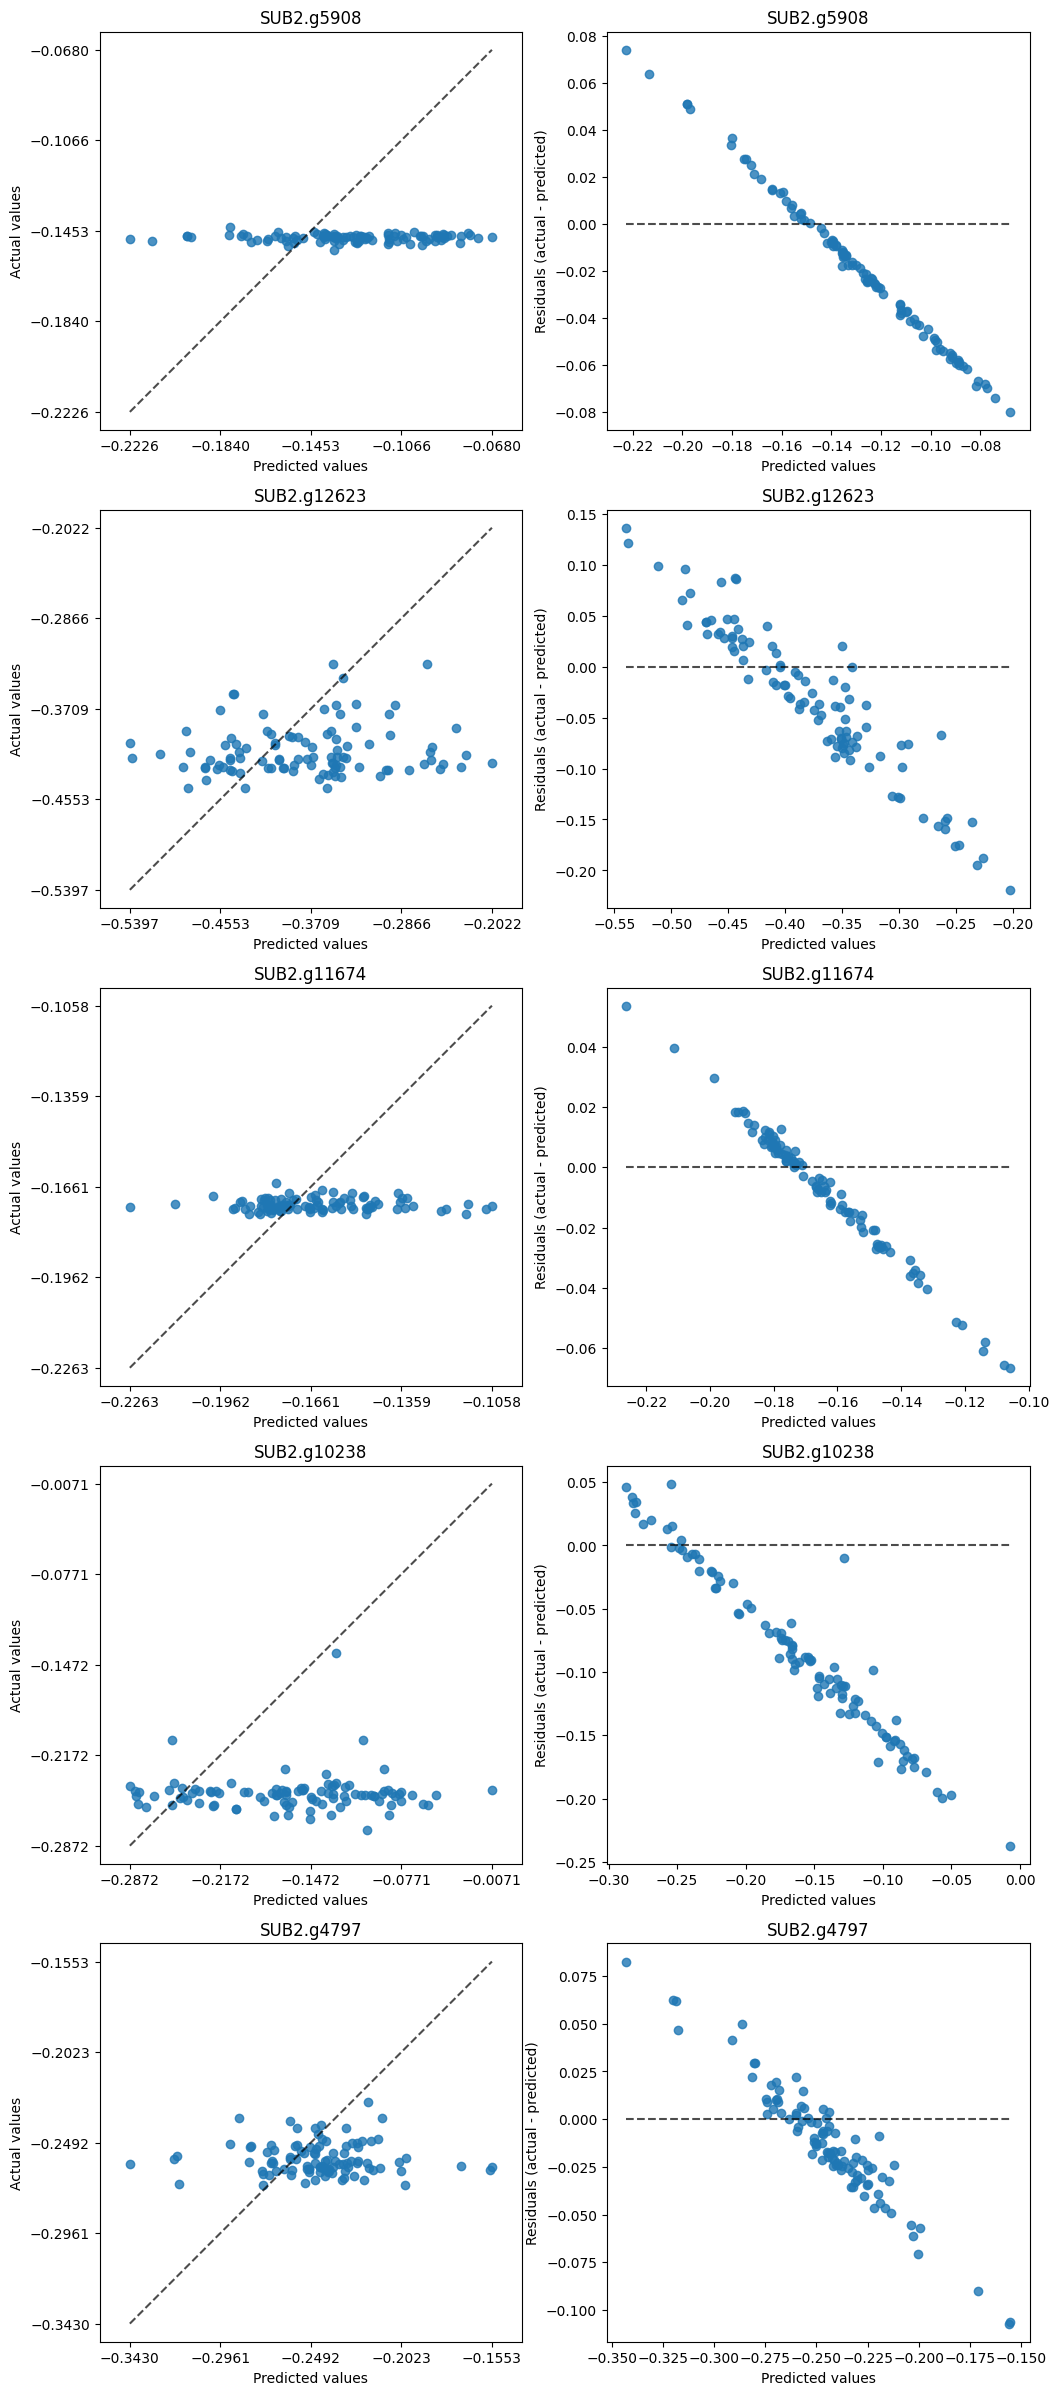

In [57]:
X_test_pt = X_test.copy()
X_test_pt["pseudo_time"] = df_pseudo_time_stem_cells.loc[X_test_pt.index].values
X_test_pt["target_pseudo_time"] = df_pseudo_time_transition_cells.loc[y_test.index].values

y_pred = model.predict(X_test_pt)
df_gen_scores = calculate_genes_r2_score(y_test, y_pred)

show_score_distribution(df_gen_scores, "r2_score")

display(df_gen_scores.head())
display(df_gen_scores.tail())

display_gene_residual_plots(y_test, y_pred, df_gen_scores.head().index, df_grn)
display_gene_residual_plots(y_test, y_pred, df_gen_scores.tail().index, df_grn)

approach - distance kernel for probability

In [52]:
# from sampling import WeightedDistanceMappingSampler

# distance = np.abs(df_pseudo_time_stem_cells.mean() - df_pseudo_time_transition_cells.mean())
# variance = (df_pseudo_time_stem_cells.to_numpy().var() + df_pseudo_time_stem_cells.to_numpy().var()) / 2
# delta = 0.1 * np.sqrt(variance)
# sampler = WeightedDistanceMappingSampler(df_pseudo_time_stem_cells.to_numpy(), df_pseudo_time_transition_cells.to_numpy(), distance, variance, delta)
# model = train_model_for_cluster_to_cluster_association(stem_cells_cluster, transition_cell_cluster, grn_mask, sampler=sampler, use_bias=True)
# weighted_grn = model.W_
# df_weighted_grn = pd.DataFrame(weighted_grn, index=df_grn.index, columns=df_grn.columns)
# df_weighted_grn.head()

In [51]:
# sampler = WeightedDistanceMappingSampler(df_pseudo_time_stem_cells.to_numpy(), df_pseudo_time_transition_cells.to_numpy(), distance, variance, delta)
# X, y = sample_associations(stem_cells_cluster, transition_cell_cluster, sampler, num_samples=100)
# y_pred = model.predict(X)
# df_gen_scores = calculate_genes_r2_score(y, y_pred)

# show_score_distribution(df_gen_scores, "r2_score")

# display(df_gen_scores.head())
# display_gene_residual_plots(y, y_pred, df_gen_scores.head().index, df_grn)

# display(df_gen_scores.tail())
# display_gene_residual_plots(y, y_pred, df_gen_scores.tail().index, df_grn)